# Multi Face Recognition using CNN and MTCNN Detector 
1) MTCNN detector is used to extract faces from the given data. 

2) Unique face coordinates are extracted and the cropped image is saved in specific folders.

3) A baseline model using ResNet architecture is defined and the model is trained on the train data and cross-validated with validation dataset.

4) The model is recreated from the saved weights for testing and the numbers corresponding to the classes are loaded from the CSV file to predict the faces from a group. )

# Mount google drive to Google Colab

---


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install necessary packages

---


In [2]:
pip install git+https://github.com/rcmalli/keras-vggface.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-3gb9slud
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-3gb9slud
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8325 sha256=6f01f3c2034bf122177679d088113a2cd8cfe84e6f5d6f670df7a5bf5891dba9
  Stored in directory: /tmp/pip-ephem-wheel-cache-stdlzr1t/wheels/08/df/86/0225d44647ab2256dbf1e006823288fe9cc86367a056e6ea2c
Successfully built keras-vggface


In [3]:
pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.7/dist-packages
Requires: pillow, scipy, six, keras, pyyaml, h5py, numpy
Required-by: 


In [4]:
!pip install keras_vggface
!pip3 install keras_applications
!pip install mtcnn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 6.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 33.6 MB/s 


In [5]:
import os
os.getcwd()

'/content'

In [6]:
base_dir = '/content/drive/MyDrive/face/'

# change directory to our base directory
os.chdir(base_dir)

In [7]:
# import necessary modules for working

import numpy as np
import csv
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
from mtcnn.mtcnn import MTCNN
from PIL import Image, ImageOps
import cv2
import os

## 1. Extract faces (Region of Interest) from given data

---


    - use MTCNN detector to detect the faces and then store the face coordinates
    - extract the bounding box of a face as an image
    - save the cropped image in a folder with respective names

1/1 [==============================] - 0s 175ms/step


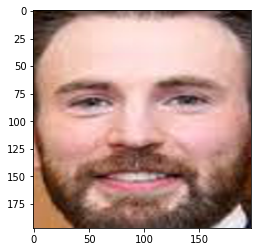

In [8]:
""" Use detector to detect faces and find the face region """

# create the detector, using default weights
detector = MTCNN()

def extract_face(filename, required_size=(197, 197), detector = detector):
    # load image from file
    pixels = plt.imread(filename)
    # detect faces in the image
    faces = detector.detect_faces(pixels)
    # print("This is faces now:\n", faces)
    # extract the bounding box from the first face
    if len(faces) == 0:
        return 0
    else:
        x1, y1, width, height = faces[0]['box']
        x2, y2 = x1 + width, y1 + height
        
        # extract the face
        face = pixels[y1:y2, x1:x2]
        # resize pixels to the model size
        img = Image.fromarray(face)

        # ImageOps.exif_transpose makes sure that there is no orientation issues after resizing
        img = ImageOps.exif_transpose(img.resize(required_size))
        return img

#Tested on one image of team member
test_extract_face = extract_face('/content/drive/MyDrive/face/team/captain/cap1.jfif')
plt.imshow(test_extract_face)

['team/captain/cap1.jfif', 'team/captain/cap2.jfif', 'team/captain/cap3.jfif', 'team/captain/cap4.jfif', 'team/captain/cap5.jpg', 'team/captain/cap6.jpg', 'team/iron man/ir1.jfif', 'team/iron man/ir2.jfif', 'team/iron man/ir3.jfif', 'team/iron man/ir4.jfif', 'team/iron man/ir5.jpg', 'team/iron man/ir6.jpg']
1/1 [==============================] - 0s 23ms/step


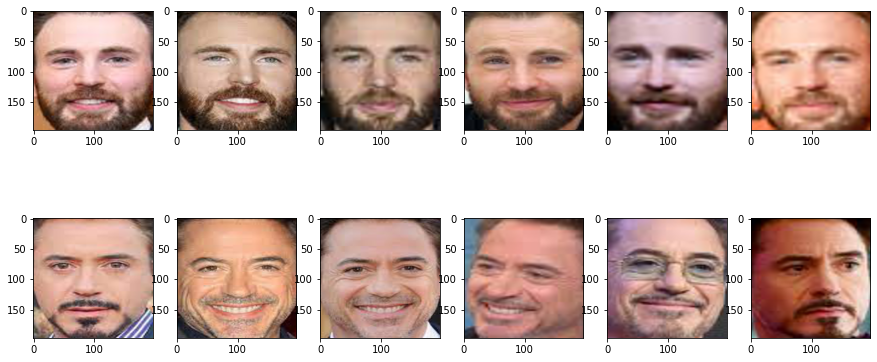

In [9]:
# Read Image
train_folders_path = 'team/*/'
all_images = glob(train_folders_path + "*.jpg")
all_images += glob(train_folders_path + "*.png")
all_images += glob(train_folders_path + "*.jpeg")
all_images += glob(train_folders_path + "*.JPG")
all_images += glob(train_folders_path + "*.PNG")
all_images += glob(train_folders_path + "*.JPEG")
all_images += glob(train_folders_path + "*.jfif")
all_images.sort()

print(all_images)

# for larger image size, instead of default size
plt.rcParams["figure.figsize"] = (15,7)

# to display images in the form of 2x6 matrix
f, axarr = plt.subplots(2,6)
i, j = 0, 0

for im in all_images:
    cropped_im = extract_face(im)
    if cropped_im == 0:
        continue
    else:
        axarr[i,j].imshow(cropped_im)
        j+=1
        if j == 6:
          i, j = 1, 0

In [10]:
""" Save the images in a folder """

# make a directory to store cropped images
if not os.path.exists('face_data'):
    os.mkdir('face_data/')

root_dir = 'face_data/'

for im in all_images:
    # print(im)
    class_dir = root_dir + im.split('/')[-2]
    if not os.path.exists(class_dir):
        os.mkdir(class_dir)
    cropped_im = extract_face(im)
    if cropped_im == 0:
        continue
    else:
      if not os.path.exists(class_dir +'/'+im.split('/')[-1]):
        cropped_im.save(class_dir +'/'+im.split('/')[-1])

1/1 [==============================] - 0s 16ms/step


## 2. Prepare data for the model

---


    - find number of people (classes) in the data
    - assign numbers for easier classification of the people
    - divide the data into train and validation sets for later use

In [11]:
import os
import os.path

retour=[]

for (root,dirs,files) in os.walk(root_dir):
    for f in files:
        if (f.endswith("jpg")| f.endswith("JPG") |f.endswith("jpeg")| f.endswith("JPEG") | f.endswith("PNG") | f.endswith("png") | f.endswith("jfif")):
            r=root.split('/')
            lr=len(r)
            retour.append((f,r[lr-1],root))

print("== Found %d items "%len(retour))
print(f)
print(root)
print(r)
print(retour)
retour.sort()

== Found 12 items 
ir6.jpg
face_data/iron man
['face_data', 'iron man']
[('cap1.jfif', 'captain', 'face_data/captain'), ('cap2.jfif', 'captain', 'face_data/captain'), ('cap3.jfif', 'captain', 'face_data/captain'), ('cap4.jfif', 'captain', 'face_data/captain'), ('cap5.jpg', 'captain', 'face_data/captain'), ('cap6.jpg', 'captain', 'face_data/captain'), ('ir1.jfif', 'iron man', 'face_data/iron man'), ('ir2.jfif', 'iron man', 'face_data/iron man'), ('ir3.jfif', 'iron man', 'face_data/iron man'), ('ir4.jfif', 'iron man', 'face_data/iron man'), ('ir5.jpg', 'iron man', 'face_data/iron man'), ('ir6.jpg', 'iron man', 'face_data/iron man')]


In [12]:
""" find total classes(here, number of people) in the given data set and assign unique indices to each class """
idx = {}

for i in retour:
    if i[1] not in idx:
        idx[i[1]]=len(idx)

print("== Found %d classes"% len(idx))
print(i)
print(i[1])
print(idx)

== Found 2 classes
('ir6.jpg', 'iron man', 'face_data/iron man')
iron man
{'captain': 0, 'iron man': 1}


In [13]:
# store all the classes and their values in a CSV file

df = pd.DataFrame.from_dict(idx, orient='index')
print(df)
df.to_csv('idx.csv')

          0
captain   0
iron man  1


In [16]:
# make empty train and val directories
os.mkdir('train')
os.mkdir('val')

In [17]:
# create train and val folders for each class
for i in idx.keys():
    print(i)
    os.mkdir('train/'+i)
    os.mkdir('val/'+i)

captain
iron man


In [18]:
# check if there is any out of index before filling randomly 4 in train and 2 in val from given 6 images of data
from random import sample, choice

for i in idx.keys():
    print(root_dir+i)
    for (root,dirs,files) in os.walk(root_dir+'/'+i):
        imgs = sample(files, 6)
        print(imgs)
        for j in range(4):
            print(root_dir+i+'/'+imgs[j], 'train/'+i+'/'+imgs[j])
        for j in range(2):
            print(root_dir+i+'/'+imgs[j+4], 'val/'+i+'/'+imgs[j+4])

face_data/captain
['cap5.jpg', 'cap4.jfif', 'cap3.jfif', 'cap2.jfif', 'cap6.jpg', 'cap1.jfif']
face_data/captain/cap5.jpg train/captain/cap5.jpg
face_data/captain/cap4.jfif train/captain/cap4.jfif
face_data/captain/cap3.jfif train/captain/cap3.jfif
face_data/captain/cap2.jfif train/captain/cap2.jfif
face_data/captain/cap6.jpg val/captain/cap6.jpg
face_data/captain/cap1.jfif val/captain/cap1.jfif
face_data/iron man
['ir1.jfif', 'ir4.jfif', 'ir6.jpg', 'ir3.jfif', 'ir2.jfif', 'ir5.jpg']
face_data/iron man/ir1.jfif train/iron man/ir1.jfif
face_data/iron man/ir4.jfif train/iron man/ir4.jfif
face_data/iron man/ir6.jpg train/iron man/ir6.jpg
face_data/iron man/ir3.jfif train/iron man/ir3.jfif
face_data/iron man/ir2.jfif val/iron man/ir2.jfif
face_data/iron man/ir5.jpg val/iron man/ir5.jpg


In [19]:
""" divide the data by filling randomly 4 in train and 2 in val from given 6 images of data """

import shutil
from random import sample, choice

for i in idx.keys():
    for (root,dirs,files) in os.walk(root_dir+'/'+i):
        imgs = sample(files, 6)
        print(imgs)
        for j in range(4):
            shutil.copy(root_dir+i+'/'+imgs[j], 'train/'+i+'/'+imgs[j])
        for j in range(2):
            shutil.copy(root_dir+i+'/'+imgs[j+4], 'val/'+i+'/'+imgs[j+4])

['cap6.jpg', 'cap2.jfif', 'cap4.jfif', 'cap3.jfif', 'cap5.jpg', 'cap1.jfif']
['ir6.jpg', 'ir5.jpg', 'ir2.jfif', 'ir1.jfif', 'ir3.jfif', 'ir4.jfif']


## 3. Train the model on data
---


    - read the image and resize it to required architecture input-size
    - define a baseline model using ResNet architecture
    - train the model on the train data and cross-validate with validation dataset

In [30]:
import numpy as np 
import pandas as pd 
import os
from random import choice, sample
from glob import glob

import keras
from keras_preprocessing import image
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Input, Dense, GlobalMaxPool2D, GlobalAvgPool2D, Concatenate, Multiply, Dropout, Subtract, Flatten
from keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from keras_vggface.utils import preprocess_input 
from keras_vggface.vggface import VGGFace
# If face any issue here just update In the keras_vggface/models.py file, 
# change the import from: from keras.engine.topology import get_source_inputs 
# to: from keras.utils.layer_utils import get_source_inputs


In [31]:
# training the model

def read_img(path):
    img = image.load_img(path, target_size=(197, 197))
    img = np.array(img).astype(np.float)
    return preprocess_input(img, version=2)

def gen(root, batch_size=16, idx = idx):
    while True:
        batch = []
        labels = []
        classes = sample(idx.keys(), batch_size)

        for i in classes:
            for (r,dirs,files) in os.walk(root+'/'+i):
                batch.append(root+'/'+i+'/'+choice(files))

        labels = np.zeros((batch_size, batch_size))
        for i in range(batch_size):
            labels[i, idx[classes[i]]] = 1
        X = np.array([read_img(x) for x in batch])

        yield X, labels

def baseline_model(classes = 2):
    base_model = VGGFace(model='resnet50', include_top=False, input_shape=(197, 197, 3))
    last_layer = base_model.get_layer('avg_pool').output
    y = Flatten(name='flatten')(last_layer)

    for x in base_model.layers[:-3]:
        x.trainable = False
    for x in base_model.layers[-3:]:
        x.trainable = True

    out = Dense(classes, activation="softmax")(y)  # (Dense from keras) here our total predictions are 2 classes

    model = Model(base_model.input, out) # Model from keras.models

    model.compile(loss="binary_crossentropy", metrics=['acc'], optimizer=Adam(0.00001))

    return model

def train_model():
    file_path = "vgg_face.h5"
    checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    reduce_on_plateau = ReduceLROnPlateau(monitor="val_acc", mode="max", factor=0.1, patience=10, verbose=1)
    es = EarlyStopping(monitor="val_acc", min_delta = 0.0001, patience=20, verbose=1)
    callbacks_list = [checkpoint, reduce_on_plateau, es]

    history = model1.fit_generator(gen('train', batch_size=2),
                                  use_multiprocessing=False,
                                  validation_data=gen('val', batch_size=2), 
                                  epochs=3, verbose=1, max_queue_size = 10,  
                                  workers=1, callbacks=callbacks_list, 
                                  steps_per_epoch=300, validation_steps=150)

classes = 2
model1 = baseline_model(classes)

train_model()

Epoch 1/3


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


298/300 [============================>.] - ETA: 0s - loss: 1.1396 - acc: 0.5621
Epoch 1: val_acc improved from -inf to 0.50000, saving model to vgg_face.h5
300/300 [==============================] - 15s 38ms/step - loss: 1.1356 - acc: 0.5617 - val_loss: 0.7198 - val_acc: 0.5000 - lr: 1.0000e-05
Epoch 2/3
300/300 [==============================] - ETA: 0s - loss: 0.2525 - acc: 0.9300
Epoch 2: val_acc improved from 0.50000 to 1.00000, saving model to vgg_face.h5
300/300 [==============================] - 7s 24ms/step - loss: 0.2525 - acc: 0.9300 - val_loss: 0.2346 - val_acc: 1.0000 - lr: 1.0000e-05
Epoch 3/3
298/300 [============================>.] - ETA: 0s - loss: 0.0876 - acc: 1.0000
Epoch 3: val_acc did not improve from 1.00000
300/300 [==============================] - 10s 34ms/step - loss: 0.0872 - acc: 1.0000 - val_loss: 0.1126 - val_acc: 1.0000 - lr: 1.0000e-05


In [32]:
""" save the trained model in form of .h5 file (type of Hierarchical Data Format) for ease of storing weights and model configuration"""

model1.save("face_recognition_model.h5")

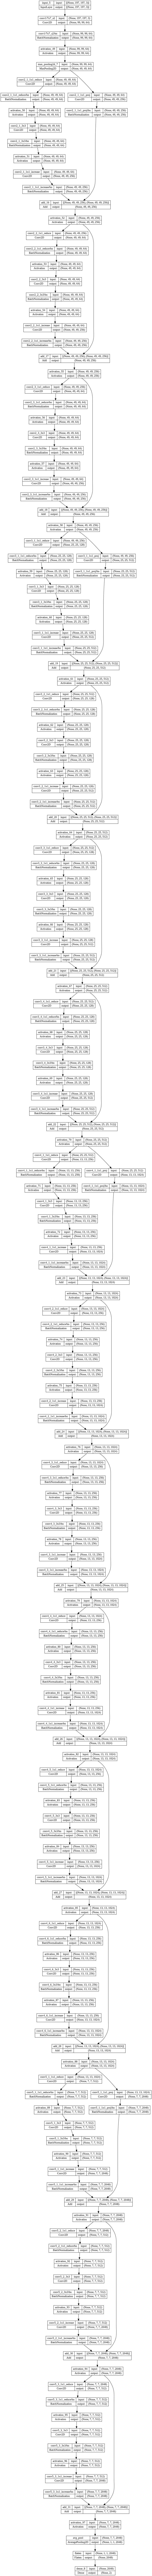

In [33]:
import keras
from keras.models import load_model
model = load_model("face_recognition_model.h5")

# visualize model
from keras.utils.vis_utils import plot_model

plot_model(model, show_shapes=True, show_layer_names=True)

## 4. Predict the classes (faces)
---


    - use the saved weights .h5 file to create a model for testing
    - load the numbers corresponding to our classes from csv file
    - predict the faces in groups

In [52]:
# from here we can use the saved model to recognise faces

import keras
from keras.models import load_model
from keras_vggface.utils import preprocess_input
from glob import glob
import numpy as np
import csv
import pandas as pd
from mtcnn.mtcnn import MTCNN
from PIL import Image
import cv2

test_imgs = 'test'

im_path = glob(test_imgs+'/*.jpg')
print(im_path)


['test/g2.jpg', 'test/g1.jpg', 'test/labeled_labeled_labeled_g1.jpg']


In [53]:
idx = pd.read_csv('idx.csv')
idx = idx.values.tolist()
print(idx)

[['captain', 0], ['iron man', 1]]


In [54]:
""" Use our trained model for testing """

model_path = 'face_recognition_model.h5'
model = load_model(model_path)

classes = 2
att = np.zeros(classes) # your classes
print(att)

[0. 0.]


In [55]:
# create the detector, using default weights
detector = MTCNN()

""" Now lets use the model to find faces in a group """

def find_person(filename, required_size=(197, 197), idx = idx, att = att):
    # load image from file
    pixels = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
    pixels = cv2.copyMakeBorder(pixels, 100, 100, 100, 100, cv2.BORDER_CONSTANT)
    pixels_l = cv2.cvtColor(pixels, cv2.COLOR_RGB2BGR)
    # detect faces in the image
    faces = detector.detect_faces(pixels)
    print(faces)
    for f in range(len(faces)):
        # extract the bounding box from the first face
        if(faces[f]['confidence']<0.9): 
            print(faces[f]['confidence'])
            continue
        x1, y1, width, height = faces[f]['box']
        x2, y2 = x1 + width, y1 + height
        # extract the face
        face = pixels[y1:y2, x1:x2]
        
        # resize pixels to the model size
        image = Image.fromarray(face)
        image = image.resize(required_size)

        face = np.asarray(image, dtype = np.float64)
        face = np.copy(face)
        face = preprocess_input(face, version=2)
        face = np.reshape(face, (1, 197, 197, 3))

        """ Predict which class (person) the face belongs to using our model """
        Y = model.predict(face)

        att[np.argmax(Y)] = 1

        # draw a rectangle around a person face
        cv2.rectangle(pixels_l, (x1, y1), (x2, y2), (66,245,224), 2)
        
        # put person name at top of the face
        cv2.putText(pixels_l, str(idx[np.argmax(Y)][0]), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.75 , (66,245,224), 2, cv2.LINE_AA)
    #print(test_imgs+'/labeled_'+filename.split('/')[-1], pixels_l)
    cv2.imwrite(test_imgs+'/labeled_'+filename.split('/')[-1], pixels_l)

    return 

for im in im_path:

    find_person(im)

1/1 [==============================] - 0s 126ms/step
[{'box': [221, 171, 147, 208], 'confidence': 0.9999771118164062, 'keypoints': {'left_eye': (259, 252), 'right_eye': (324, 256), 'nose': (287, 297), 'mouth_left': (263, 328), 'mouth_right': (318, 331)}}, {'box': [545, 200, 148, 204], 'confidence': 0.999610960483551, 'keypoints': {'left_eye': (578, 285), 'right_eye': (642, 282), 'nose': (605, 321), 'mouth_left': (580, 350), 'mouth_right': (646, 346)}}]
1/1 [==============================] - 0s 19ms/step
[{'box': [289, 126, 36, 53], 'confidence': 0.9999969005584717, 'keypoints': {'left_eye': (299, 146), 'right_eye': (315, 148), 'nose': (307, 155), 'mouth_left': (298, 165), 'mouth_right': (313, 166)}}, {'box': [166, 124, 35, 48], 'confidence': 0.9999736547470093, 'keypoints': {'left_eye': (176, 141), 'right_eye': (192, 145), 'nose': (184, 152), 'mouth_left': (175, 160), 'mouth_right': (188, 162)}}]
1/1 [==============================] - 0s 54ms/step
[{'box': [468, 424, 31, 47], 'confiden

['test/g1.jpg', 'test/g2.jpg', 'test/labeled_g1.jpg', 'test/labeled_g2.jpg']


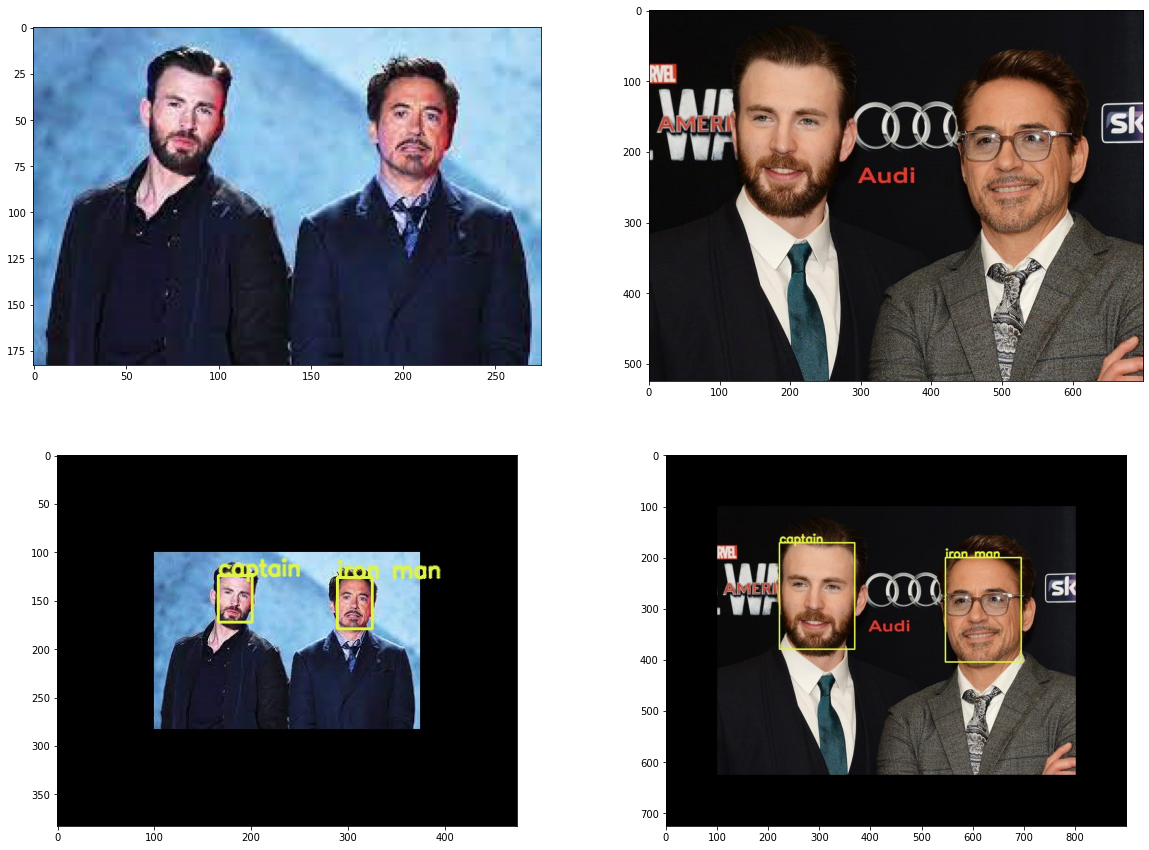

In [58]:
test_folders_path = 'test/*'
all_images = glob(test_folders_path + "*.jpg")
all_images += glob(test_folders_path + "*.png")
all_images += glob(test_folders_path + "*.jpeg")
all_images += glob(test_folders_path + "*.JPG")
all_images += glob(test_folders_path + "*.PNG")
all_images += glob(test_folders_path + "*.JPEG")
all_images += glob(test_folders_path + "*.jfif")
all_images.sort()

print(all_images)

# for larger image size, instead of default size
plt.rcParams["figure.figsize"] = (20,15)

# to display images in the form of 2x2 matrix
f, axarr = plt.subplots(2,2)
i, j = 0, 0

for im in all_images:
    pixels = plt.imread(im)    
    axarr[i,j].imshow(pixels)
    j+=1
    if j == 2:
      i, j = 1, 0

###Yayy!! you've successfully completed training and testing a face recognition model
Remember, AI is not just about coding in some fancy programming langauage, its about how well can we apply concepts to come up with better solutions. 
Sometimes ML or AI is more of an art rather than science! 

**Just keep learning!!!**